In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from PIL import Image

In [2]:

DATASET_DIR = r"C:\Rice grain\Rice_Image_Dataset" 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5    

In [3]:
if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"Dataset not found: {DATASET_DIR}")

In [4]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [5]:

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint("rice_grain_model.h5", save_best_only=True, monitor='val_accuracy')
]


In [8]:

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)



C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4067 - loss: 1.3037

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5530s 3s/step - accuracy: 0.4067 - loss: 1.3037 - val_accuracy: 0.5075 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5348s 3s/step - accuracy: 0.4823 - loss: 1.1412 - val_accuracy: 0.4793 - val_loss: 1.0789 - learning_rate: 0.0010
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4936 - loss: 1.1189

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5354s 3s/step - accuracy: 0.4936 - loss: 1.1189 - val_accuracy: 0.5411 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5362s 3s/step - accuracy: 0.4960 - loss: 1.1142 - val_accuracy: 0.5321 - val_loss: 0.9748 - learning_rate: 0.0010
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5422s 3s/step - accuracy: 0.5010 - loss: 1.0942 - val_accuracy: 0.4924 - val_loss: 1.0273 - learning_rate: 0.0010


469/469 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step

 Classification Report:
              precision    recall  f1-score   support

     Arborio       0.15      0.01      0.01      3000
     Basmati       0.89      0.62      0.73      3000
      Ipsala       0.97      0.92      0.94      3000
     Jasmine       0.37      0.13      0.19      3000
   Karacadag       0.34      1.00      0.50      3000

    accuracy                           0.53     15000
   macro avg       0.54      0.53      0.47     15000
weighted avg       0.54      0.53      0.47     15000



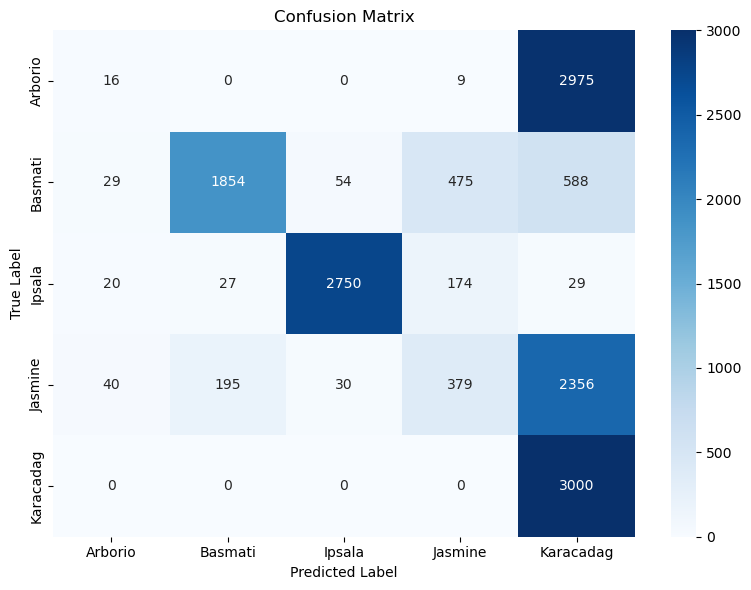

469/469 ━━━━━━━━━━━━━━━━━━━━ 1017s 2s/step - accuracy: 0.3117 - loss: 1.0229

 Validation Accuracy: 53.11%


In [10]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_data.reset()  # Ensure correct label alignment
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())


print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


val_loss, val_acc = model.evaluate(val_data)
print(f"\n Validation Accuracy: {val_acc * 100:.2f}%")

